In [ ]:
!pip --default-timeout=1000 install PySide2  

In [29]:
from PySide2 import QtWidgets, QtGui, QtCore
from PySide2.QtWidgets import QWidget, QMainWindow, QApplication, QMessageBox, QLabel, QLineEdit, QPushButton, QVBoxLayout
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.backends.backend_qt5agg import NavigationToolbar2QT as NavigationToolbar
from fractions import Fraction
import numpy as np
import random
import sys
import re

# matplotlib.use('Qt5Agg')

In [30]:
def Calculate_Y(equation:str, x:int):
    
    # Define Function
    def equation_function(x):
        return eval(equation.replace(' ', '').replace('X', 'x').replace('^', '**'))
    
    return equation_function(x)

In [31]:
def FunctionGraph(figure, equation:str, Xmin:int, Xmax:int, num_samples:int =100000):
    
    # Define Function
    def equation_function(x):
        return eval(equation.replace(' ', '').replace('X', 'x').replace('^', '**'))
    
    # Create x and y Ranges
    x = np.linspace(Xmin, Xmax, num_samples)
    y = np.empty(shape=x.shape[0])
    for i in range(0, x.shape[0]):
        y[i] = equation_function(x[i])

    # Plot the Data 
    ax = figure.add_subplot(111)
    ax.set_title('Plotting Functions in Matplotlib', size=14)
    ax.plot(x, y, label=equation, color='red')

    # Modify the Axes Limits
    # ax.set_xlim(-100, 100)
    # self.ax.set_ylim(-1000, 1000)

    # Set the origin (0, 0) color
    ax.axhline(y=0, color='red', linewidth=0.8)
    ax.axvline(x=0, color='red', linewidth=0.8)
    
    ax.legend()
    ax.grid()

In [32]:
class ValidationCriteria:

    def validate_equation(self, Function: str):
        equation = Function.replace('X', 'x').replace(' ', '')
        supported_operators = 'x+-/*^0123456789'

        if len(equation)==0:
            return 'empty'
        else:
            
            for char in equation:
                if char not in supported_operators:
                    return 'invalid syntax'

            try:
                def equation_function(x):
                    return eval(equation.replace('^', '**'))
                equation_function(1)
            except Exception as e:
                return 'invalid syntax'
            
            return equation

            
    def to_integer(self, num: str):
        try:
            fraction_obj = Fraction(num)

            # Extract the numerator and denominator from the Fraction object
            numerator = fraction_obj.numerator
            denominator = fraction_obj.denominator

            # Convert the fraction to an integer
            integer_value = numerator // denominator
            return integer_value
    
        except Exception as e:
            return 'invalid syntax'
    

    def validate_number(self, num: str):

        if len(num) == 0:
            return 'empty'
        else:
            return self.to_integer(num)

    
    def validate_range(self, Xmin: int, Xmax: int):
        if Xmin > Xmax:
            return 0
        else:
            return 1

In [35]:
class MainWindow(QWidget):
    
    def __init__(self):

        super().__init__()
        self.setWindowTitle('Function Plotter')
        self.resize(1500, 875)
        self.setLayoutDirection(QtCore.Qt.LeftToRight)
        self.setStyleSheet("font: 11pt \"Calibri (body)\";")
        self.setEnabled(True)
        self.setMinimumSize(QtCore.QSize(1500, 875))
    
        # Create Central Widget for Main Window
        self.CentralWidget = QWidget()
        self.CentralWidget.setParent(self)  # OR  # MainWindow.setCentralWidget(self.CentralWidget)
        self.CentralWidget.setObjectName('Central Widget')
        
        # Equation -> Label & TextBox 
        self.equation_label = QLabel(self.CentralWidget)
        self.equation_label.setGeometry(QtCore.QRect(1000, 125, 250, 50))
        self.equation_label.setText('Equation: ')
        self.equation_label.setStyleSheet("font: 22pt \"Calibri (body)\";")
        self.equation_label.setObjectName('Equation Label')

        self.equation = QLineEdit(self.CentralWidget)
        self.equation.setGeometry(QtCore.QRect(1170, 138, 250, 30))
        self.equation.setStyleSheet("font: 16pt \"Calibri (body)\";")
        self.equation.setObjectName('Equation Line Edit')

        # Xmin -> Label & TextBox
        self.Xmin_label = QLabel(self.CentralWidget)
        self.Xmin_label.setGeometry(QtCore.QRect(1000, 224, 250, 50))
        self.Xmin_label.setText('X Min: ')
        self.Xmin_label.setStyleSheet("font: 22pt \"Calibri (body)\";")
        self.Xmin_label.setObjectName('Xmin Label')

        self.Xmin = QLineEdit(self.CentralWidget)
        self.Xmin.setGeometry(QtCore.QRect(1170, 238, 250, 30))
        self.Xmin.setStyleSheet("font: 16pt \"Calibri (body)\";")
        self.Xmin.setObjectName('Xmin Line Edit')

        # Xmax -> Label & TextBox
        self.Xmax_label = QLabel(self.CentralWidget)
        self.Xmax_label.setGeometry(QtCore.QRect(1000, 323, 250, 50))
        self.Xmax_label.setText('X Max: ')
        self.Xmax_label.setStyleSheet("font: 22pt \"Calibri (body)\";")
        self.Xmax_label.setObjectName('Xmax Label')
        
        self.Xmax = QLineEdit(self.CentralWidget)
        self.Xmax.setGeometry(QtCore.QRect(1170, 338, 250, 30))
        self.Xmax.setStyleSheet("font: 16pt \"Calibri (body)\";")
        self.Xmax.setObjectName('Xmax Line Edit')

        # Plot Button
        self.plot_button = QPushButton(self.CentralWidget,clicked=lambda: self.update_plot())
        self.plot_button.setGeometry(QtCore.QRect(1060, 450, 120, 35))
        self.plot_button.setStyleSheet("font: 20pt \"Calibri (body)\";")
        self.plot_button.setText('Plot')
        self.plot_button.setObjectName('Plot Button')

        # Exit Button
        self.exit_button = QPushButton(self.CentralWidget,clicked=lambda: self.close())
        self.exit_button.setGeometry(QtCore.QRect(1240, 450, 120, 35))
        self.exit_button.setStyleSheet("font: 20pt \"Calibri (body)\";")
        self.exit_button.setText('Exit')
        self.exit_button.setObjectName('Exit Button')

        # ============ Initial Graph ============

        # a figure instance to plot on
        self.figure = plt.figure(figsize=(5, 5), dpi=175)

		# this is the Canvas Widget that displays the 'figure'
        # it takes the 'figure' instance as a parameter to __init__
        self.canvas = FigureCanvas(self.figure)
        self.canvas.setParent(self.CentralWidget)
        self.canvas.setGeometry(QtCore.QRect(0, 50, 920, 820))

		# this is the Navigation widget
		# it takes the Canvas widget and a parent
        self.toolbar = NavigationToolbar(self.canvas, self.CentralWidget)

        # Keep Track The Times of Changes
        self.update_times = 0

    
    def error_message(self, message: str):
        QMessageBox.about(self.CentralWidget, 'Error', message)


    def update_plot(self):

        try:
            # clearing old figure
            self.figure.clear()
            
            validation = ValidationCriteria()

            # validate equation
            val_equation = validation.validate_equation(self.equation.text())
            if val_equation == 'empty':
                self.error_message('Functon Field Is Empty')
                return
            elif val_equation == 'invalid syntax':
                self.error_message('Invalid Syntax, The Supported Operators: + - / * ^')
                return
            
            # validate Xmin 
            val_Xmin = validation.validate_number(self.Xmin.text())
            if val_Xmin == 'empty':
                self.error_message('Xmin Field Is Empty')
                return
            elif val_Xmin == 'invalid syntax':
                self.error_message('Invalid Value For Xmin, Only Numerical Values Are Allowed')
                return

            # validate Xmax
            val_Xmax = validation.validate_number(self.Xmax.text())
            if val_Xmax == 'empty':
                self.error_message('Xmax Field Is Empty')
                return
            elif val_Xmax == 'invalid syntax':
                self.error_message('Invalid Value For Xmax, Only Numerical Values Are Allowed')
                return
            
            # validate range 
            val_range = validation.validate_range(val_Xmin, val_Xmax)
            if val_range == 0:
                self.error_message('Invalid Range, Xmin Must Be Lower Than Or Equal To Xmax')
                return

            # plot new figure
            FunctionGraph(self.figure, val_equation, val_Xmin, val_Xmax)

            # refresh canvas
            self.canvas.draw()

            self.update_times += 1

        except Exception as e:
            self.error_message(e)
            return

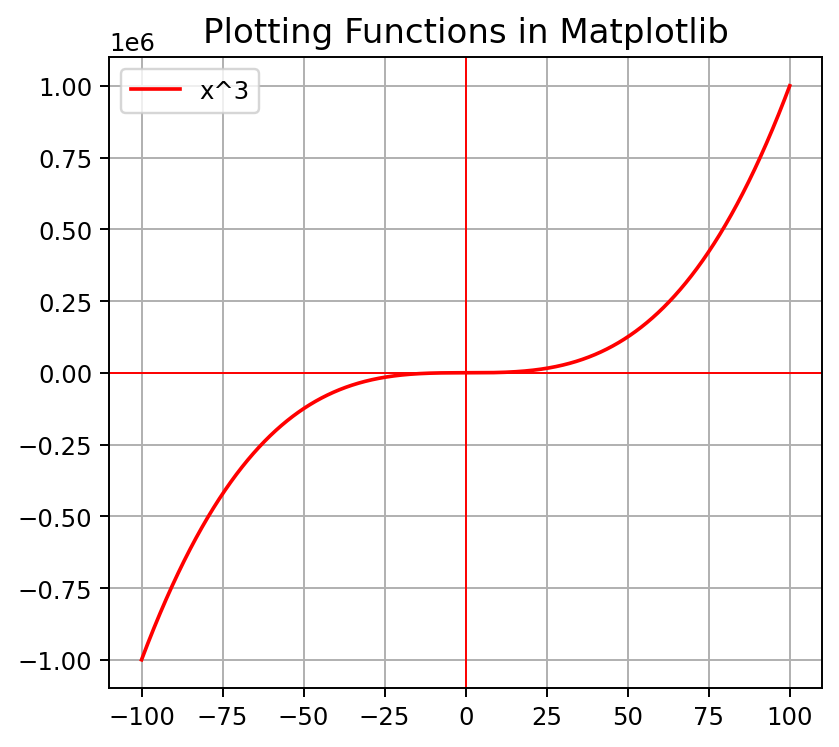

In [36]:
if __name__ == "__main__":

    # create new app
    if not QtWidgets.QApplication.instance():
        app = QtWidgets.QApplication(sys.argv)
    else:
        app = QtWidgets.QApplication.instance()

    # create main window
    mainwindow = MainWindow()

    # invoke show function
    mainwindow.show()

    # to kee in loop invoke exec_() function
    app.exec_()

In [5]:
# class MainWindow(QWidget):
    
#     def __init__(self):

#         super().__init__()
#         self.setWindowTitle('Function Plotter')
#         self.resize(1500, 875)
#         self.setLayoutDirection(QtCore.Qt.LeftToRight)
#         self.setStyleSheet("font: 11pt \"Calibri (body)\";")
#         self.setEnabled(True)
#         self.setMinimumSize(QtCore.QSize(1500, 875))


In [6]:
# class UserInterface(object):
     
#     def __init__(self, MainWindow):

#         self.CentralWidget = QWidget()
#         self.CentralWidget.setParent(MainWindow)  # OR  # MainWindow.setCentralWidget(self.CentralWidget)
#         self.CentralWidget.setObjectName('Central Widget')
        
#         # Equation -> Label & TextBox 
#         self.equation_label = QLabel(self.CentralWidget)
#         self.equation_label.setGeometry(QtCore.QRect(1000, 125, 250, 50))
#         self.equation_label.setText('Equation: ')
#         self.equation_label.setStyleSheet("font: 22pt \"Calibri (body)\";")
#         self.equation_label.setObjectName('Equation Label')

#         self.equation = QLineEdit(self.CentralWidget)
#         self.equation.setGeometry(QtCore.QRect(1170, 138, 250, 30))
#         self.equation.setStyleSheet("font: 16pt \"Calibri (body)\";")
#         self.equation.setObjectName('Equation Line Edit')

#         # Xmin -> Label & TextBox
#         self.Xmin_label = QLabel(self.CentralWidget)
#         self.Xmin_label.setGeometry(QtCore.QRect(1000, 224, 250, 50))
#         self.Xmin_label.setText('X Min: ')
#         self.Xmin_label.setStyleSheet("font: 22pt \"Calibri (body)\";")
#         self.Xmin_label.setObjectName('Xmin Label')

#         self.Xmin = QLineEdit(self.CentralWidget)
#         self.Xmin.setGeometry(QtCore.QRect(1170, 238, 250, 30))
#         self.Xmin.setStyleSheet("font: 16pt \"Calibri (body)\";")
#         self.Xmin.setObjectName('Xmin Line Edit')

#         # Xmax -> Label & TextBox
#         self.Xmax_label = QLabel(self.CentralWidget)
#         self.Xmax_label.setGeometry(QtCore.QRect(1000, 323, 250, 50))
#         self.Xmax_label.setText('X Max: ')
#         self.Xmax_label.setStyleSheet("font: 22pt \"Calibri (body)\";")
#         self.Xmax_label.setObjectName('Xmax Label')
        
#         self.Xmax = QLineEdit(self.CentralWidget)
#         self.Xmax.setGeometry(QtCore.QRect(1170, 338, 250, 30))
#         self.Xmax.setStyleSheet("font: 16pt \"Calibri (body)\";")
#         self.Xmax.setObjectName('Xmax Line Edit')

#         # Plot Button
#         self.plot_button = QPushButton(self.CentralWidget,clicked=lambda: self.update_plot())
#         self.plot_button.setGeometry(QtCore.QRect(1060, 450, 120, 35))
#         self.plot_button.setStyleSheet("font: 20pt \"Calibri (body)\";")
#         self.plot_button.setText('Plot')
#         self.plot_button.setObjectName('Plot Button')

#         # Exit Button
#         self.exit_button = QPushButton(self.CentralWidget,clicked=lambda: MainWindow.close())
#         self.exit_button.setGeometry(QtCore.QRect(1240, 450, 120, 35))
#         self.exit_button.setStyleSheet("font: 20pt \"Calibri (body)\";")
#         self.exit_button.setText('Exit')
#         self.exit_button.setObjectName('Exit Button')

#         # ============ Initial Graph ============

#         # a figure instance to plot on
#         self.figure = plt.figure(figsize=(5, 5), dpi=175)

# 		# this is the Canvas Widget that displays the 'figure'
#         # it takes the 'figure' instance as a parameter to __init__
#         self.canvas = FigureCanvas(self.figure)
#         self.canvas.setParent(self.CentralWidget)
#         self.canvas.setGeometry(QtCore.QRect(0, 50, 920, 820))

# 		# this is the Navigation widget
# 		# it takes the Canvas widget and a parent
#         self.toolbar = NavigationToolbar(self.canvas, self.CentralWidget)

    
#     def error_message(self, message: str):
#         QMessageBox.about(self.CentralWidget, 'Error', message)


#     def update_plot(self):

#         try:
#             # clearing old figure
#             self.figure.clear()
            
#             validation = ValidationCriteria()

#             # validate equation
#             val_equation = validation.validate_equation(self.equation.text())
#             if val_equation == 'empty':
#                 self.error_message('Functon Field Is Empty')
#                 return
#             elif val_equation == 'invalid syntax':
#                 self.error_message('Invalid Syntax, The Supported Operators: + - / * ^')
#                 return
            
#             # validate Xmin 
#             val_Xmin = validation.validate_number(self.Xmin.text())
#             if val_Xmin == 'empty':
#                 self.error_message('Xmin Field Is Empty')
#                 return
#             elif val_Xmin == 'invalid syntax':
#                 self.error_message('Invalid Value For Xmin, Only Numerical Values Are Allowed')
#                 return

#             # validate Xmax
#             val_Xmax = validation.validate_number(self.Xmax.text())
#             if val_Xmax == 'empty':
#                 self.error_message('Xmax Field Is Empty')
#                 return
#             elif val_Xmax == 'invalid syntax':
#                 self.error_message('Invalid Value For Xmax, Only Numerical Values Are Allowed')
#                 return
            
#             # validate range 
#             val_range = validation.validate_range(val_Xmin, val_Xmax)
#             if val_range == 0:
#                 self.error_message('Invalid Range, Xmin Must Be Lower Than Or Equal To Xmax')
#                 return

#             # plot new figure
#             FunctionGraph(self.figure, val_equation, val_Xmin, val_Xmax)

#             # refresh canvas
#             self.canvas.draw()

#         except Exception as e:
#             self.error_message(e)
#             return

In [14]:
# if __name__ == "__main__":

#     # create new app
#     if not QtWidgets.QApplication.instance():
#         app = QtWidgets.QApplication(sys.argv)
#     else:
#         app = QtWidgets.QApplication.instance()

#     # create main window
#     mainwindow = MainWindow()

#     # create GUI for main window
#     UI = UserInterface(mainwindow)

#     # invoke show function
#     mainwindow.show()

#     # to kee in loop invoke exec_() function
#     app.exec_()